# Testing the coefficients in a real simulation where the feedback is generated by the readout.

In [2]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

# plt.rcParams['figure.figsize'] = 5, 10

import numpy
import sys
import os

import save_load_file as slf

from generates_lsm_start import *

In [3]:
import matplotlib 

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# matplotlib.rcdefaults() # restores to the default values

# http://matplotlib.org/api/matplotlib_configuration_api.html#matplotlib.rc

# Main functions to the 2 joint arm simulation

In [4]:
from simulation_2DoF_Arm_physics import *
reload(sys.modules['simulation_2DoF_Arm_physics']) # Makes sure the interpreter is going to reload the module

<module 'simulation_2DoF_Arm_physics' from 'simulation_2DoF_Arm_physics.pyc'>

# Start of the simulation!

In [5]:
trajectories = [[[0.75,0.25],[0.0,0.5]],\
                [[0.25,0.60],[-0.25,0.60]],\
                [[-0.10,0.75],[-0.10,0.25]],\
                [[-0.75,0.50],[-0.40,0.00]]]

In [6]:
# First the arm parametres according to Joshi/Maass paper
aparams = {
    'l1' : 0.5, # metres
    'l2' : 0.5,
    'lc1' : 0.25,
    'lc2' : 0.25,
    'm1' : 1.0, # kg
    'm2' : 1.0,
    'i1' : 0.03, # kg*m*m
    'i2' : 0.03
}

In [7]:
# Total time spent during the movement (in seconds)
MT = 0.5
# Simulation time step (in seconds)
time_step = 2/1000.0
# Number of neurons at each input layer (defines the resolution of the system)
Ninput = 50

In [8]:
t_mov=numpy.arange(0, MT, time_step) # t starts in 0s and steps time_step(s) until reaches MT(s)

In [37]:
# Experiment identifier
sim_sets = ["set_A", "set_B", "set_C", "set_D"]

sim_set = sim_sets[0]

sim_set_name = "Set "+sim_set[-1]
total_trials = 50

base_dir = "2DofArm_simulation_data"

# Reads all the experiments to check which range of torques is necessary to control the arm
# These values are based ONLY in the 4 trajectories used!
torques_all_1 = [] # numpy.array([]);
torques_all_2 = [] # numpy.array([]);
number_of_trajectories = len(trajectories)
for i in range(1,number_of_trajectories+1):
    states,torques = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(i)+".gzpickle")
    torques_all_1 = numpy.concatenate((torques_all_1,torques[:,0])) # torques joint 1
    torques_all_2 = numpy.concatenate((torques_all_2,torques[:,1])) # torques joint 2

In [38]:
# Creates the 50 possible discrete values of torques for each joint (probably will be different)
torques_values_1=numpy.linspace(torques_all_1.min(),torques_all_1.max(),num=50)
torques_values_2=numpy.linspace(torques_all_2.min(),torques_all_2.max(),num=50)

In [39]:
torques_values_1,torques_values_2

(array([-11.92838588, -11.48229306, -11.03620023, -10.59010741,
        -10.14401458,  -9.69792176,  -9.25182893,  -8.8057361 ,
         -8.35964328,  -7.91355045,  -7.46745763,  -7.0213648 ,
         -6.57527198,  -6.12917915,  -5.68308633,  -5.2369935 ,
         -4.79090067,  -4.34480785,  -3.89871502,  -3.4526222 ,
         -3.00652937,  -2.56043655,  -2.11434372,  -1.66825089,
         -1.22215807,  -0.77606524,  -0.32997242,   0.11612041,
          0.56221323,   1.00830606,   1.45439889,   1.90049171,
          2.34658454,   2.79267736,   3.23877019,   3.68486301,
          4.13095584,   4.57704866,   5.02314149,   5.46923432,
          5.91532714,   6.36141997,   6.80751279,   7.25360562,
          7.69969844,   8.14579127,   8.5918841 ,   9.03797692,
          9.48406975,   9.93016257]),
 array([-2.29985852, -2.1845042 , -2.06914987, -1.95379555, -1.83844123,
        -1.72308691, -1.60773259, -1.49237827, -1.37702395, -1.26166963,
        -1.14631531, -1.03096099, -0.91560667, -

In [40]:
# Creates the 50 possible discrete values of angles for each joint
teta1_values=numpy.linspace(-numpy.pi/6,numpy.pi,num=50)
teta2_values=numpy.linspace(0,numpy.pi,num=50)

In [41]:
# These are the 50 possible values that the input neurons will represent (x,y) 
x_values=numpy.linspace(-1,1,num=50)
y_values=numpy.linspace(-1,1,num=50)

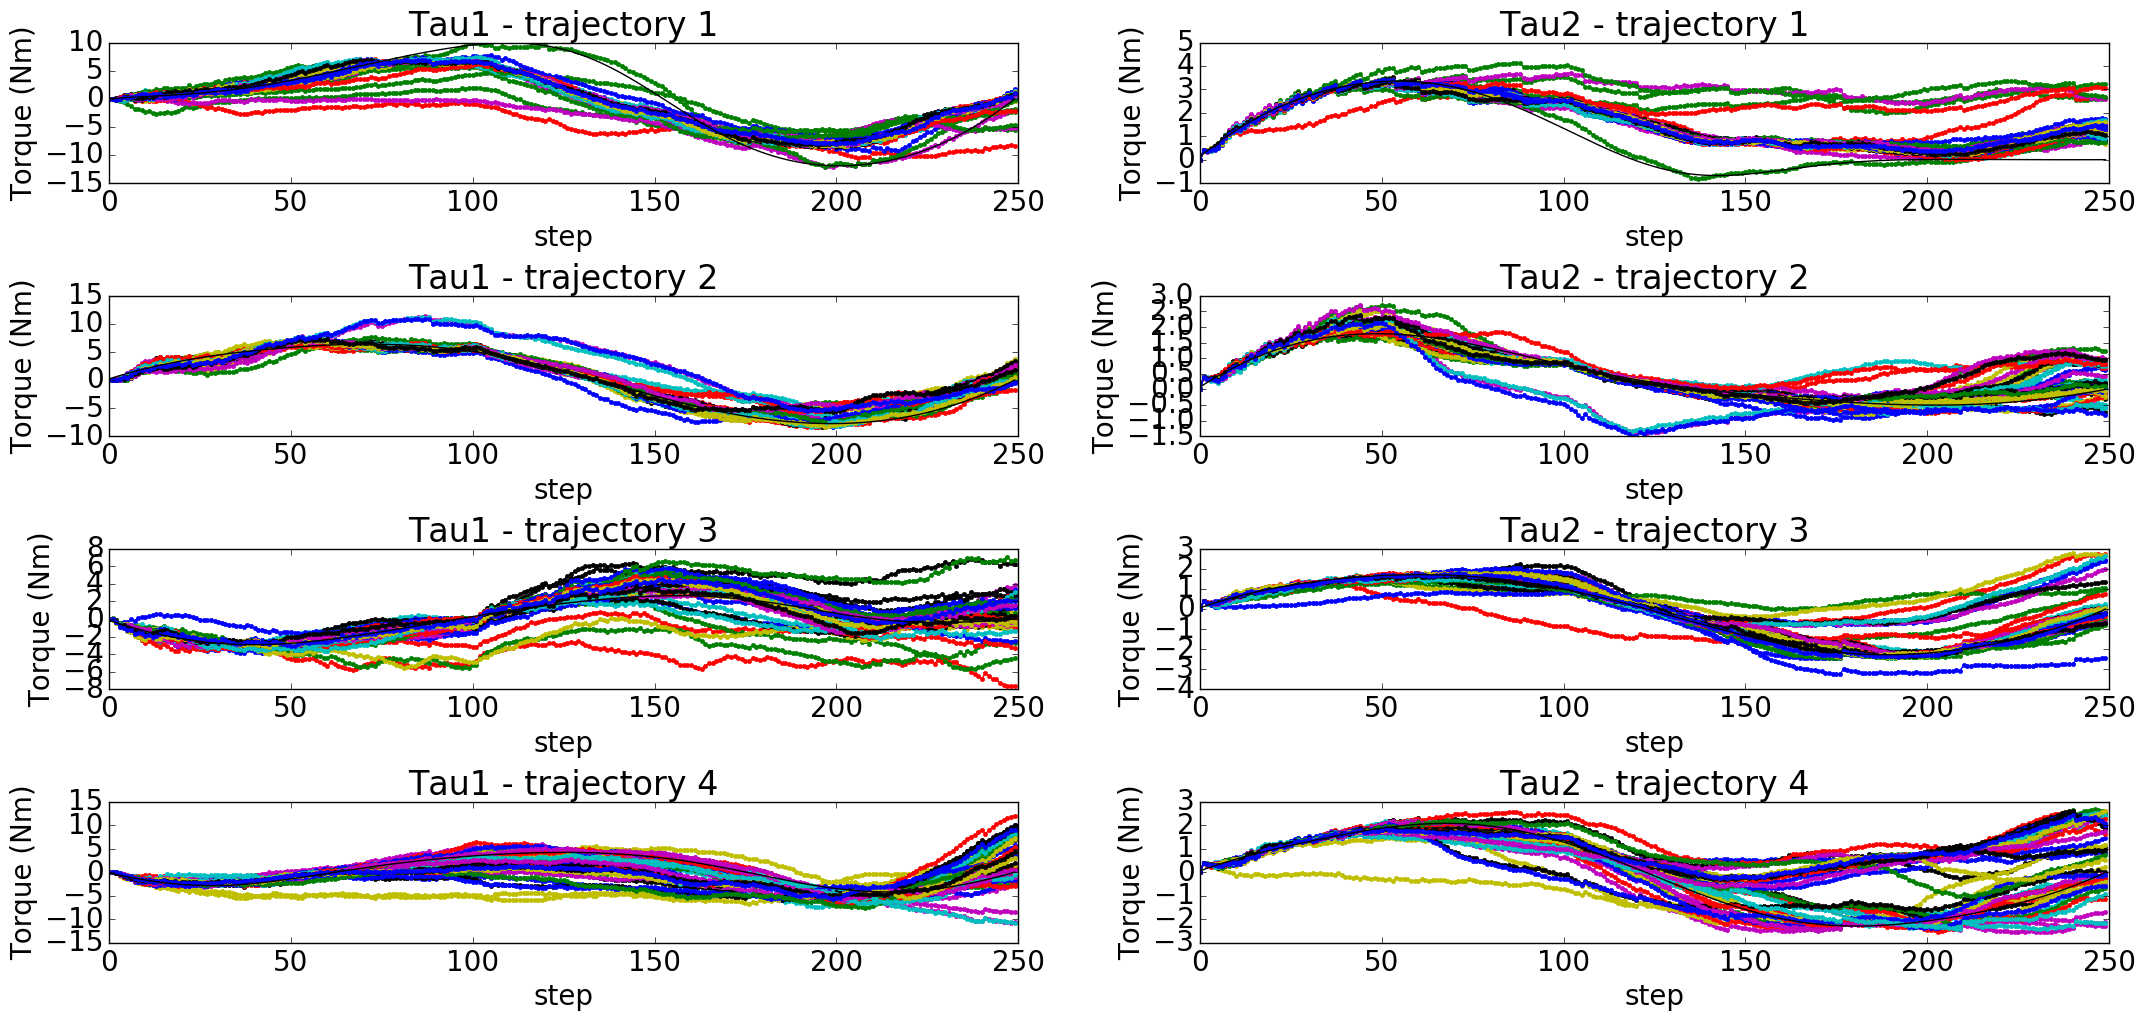

In [42]:
noiselevel=0
decimationlevel=0

plt.figure(figsize =(20,10))

subploti=1
for tji in range(1,5):
    torques_original = numpy.array([torques_all_1[(tji-1)*250:(tji)*250],torques_all_2[(tji-1)*250:(tji)*250]])
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    ymin = numpy.array([torques_all_1.min(),torques_all_2.min()]).min()
    ymax = numpy.array([torques_all_1.max(),torques_all_2.max()]).max()

    torques_read_1=numpy.zeros((total_trials,250))
    torques_read_2=numpy.zeros((total_trials,250))


    plt.subplot(4,2,subploti)
    for run_number in range(1,total_trials+1):
        torques = slf.load_from_file("./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        torques_read_1[run_number-1] = numpy.copy(torques[:,0])
        plt.plot(torques[:,0],'.-',label="Tau1 Calculated")
    plt.plot(torques_original[0,:],'k-',label="Tau1 Original")
    plt.ylabel("Torque (Nm)")
    plt.xlabel("step")
    plt.title("Tau1 - trajectory " + str(tji))
    plt.xlim(0,250)
    # plt.legend()

    plt.subplot(4,2,subploti+1)
    subploti+=2
    for run_number in range(1,total_trials+1):
        torques = slf.load_from_file("./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        torques_read_2[run_number-1] = numpy.copy(torques[:,1])
        plt.plot(torques[:,1],'.-',label="Tau2 Calculated")
    plt.plot(torques_original[1,:],'k-',label="Tau2 Original")
    plt.xlim(0,250)
    plt.ylabel("Torque (Nm)")
    plt.xlabel("step")
    plt.title("Tau2 - trajectory " + str(tji))
    # plt.ylim(ymin,ymax)
    # plt.legend()
    
plt.subplots_adjust(left=0, bottom=.1, right=1, top=1, wspace=.2, hspace=.8)
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_testing_all_"+sim_set+".pdf", bbox_inches='tight',pad_inches=1)
plt.show()

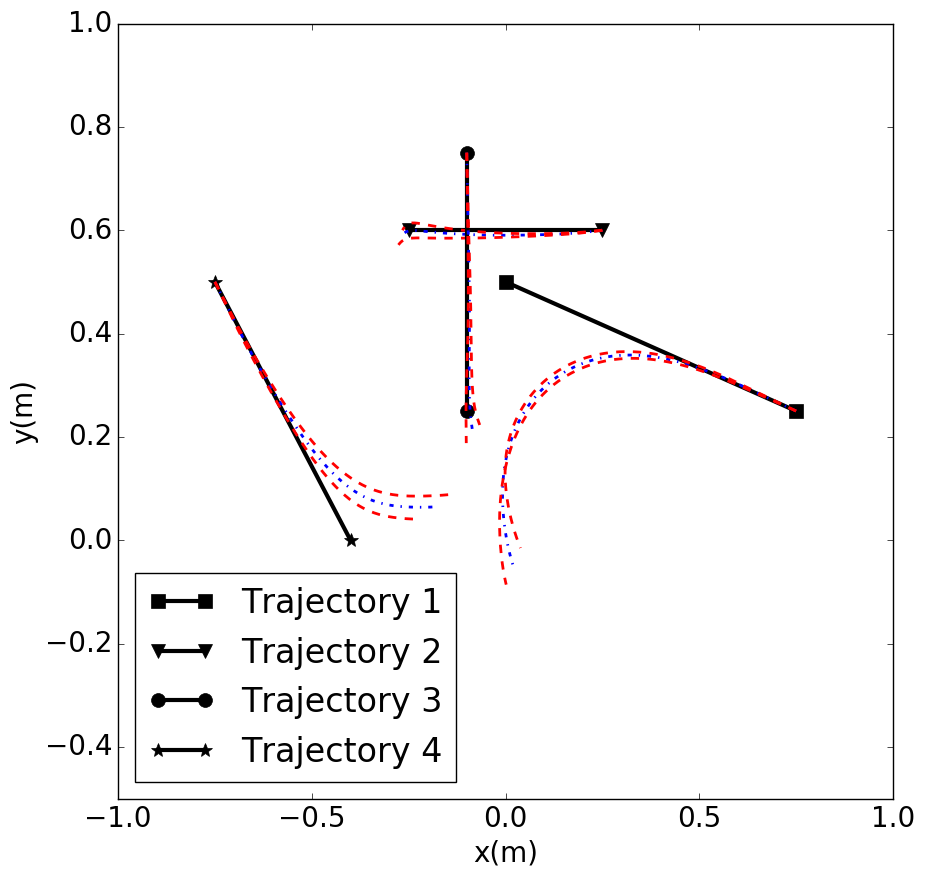

In [43]:
plt.figure(figsize =(10,10))
noiselevel=0
decimationlevel=0

H_list = numpy.zeros((4,total_trials,250,2))

traj_results = []

for tji in range(1,5):
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    for run_number in range(1,total_trials+1):
        teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        H,E = joints_to_hand(teta,aparams)
        H_list[tji-1,run_number-1,:]=numpy.copy(H)
    H_list_mean1 = H_list[tji-1,:,:,0].mean(axis=0)
    H_list_mean2 = H_list[tji-1,:,:,1].mean(axis=0)
    std_error1 = H_list[tji-1,:,:,0].std(axis=0)/numpy.sqrt(total_trials)
    std_error2 = H_list[tji-1,:,:,1].std(axis=0)/numpy.sqrt(total_trials)
    plt.plot([xstart,xdest],[ystart,ydest],['ks-','kv-','ko-','k*-'][tji-1], markersize=10, linewidth=3, label='Trajectory '+str(tji))    
    plt.plot(H_list_mean1,H_list_mean2,'b-.',linewidth=2)
    plt.plot(H_list_mean1+std_error1,H_list_mean2+std_error2,'r--',linewidth=2)
    plt.plot(H_list_mean1-std_error1,H_list_mean2-std_error2,'r--',linewidth=2)
    
    traj_results.append(H_list)

    
slf.save_to_file(traj_results,"./"+"traj_results"+sim_set+".pickles")
# plt.title("Trajectories - Mean and Standard Error - " + sim_set_name)
plt.xlabel("x(m)")
plt.ylabel("y(m)")

plt.legend(loc=0)

plt.xlim(-1,1)
plt.ylim(-.5,1)
plt.savefig("All_Trajectories_mean_stderr_"+sim_set+".png", bbox_inches='tight',pad_inches=1,dpi=300)
plt.show()

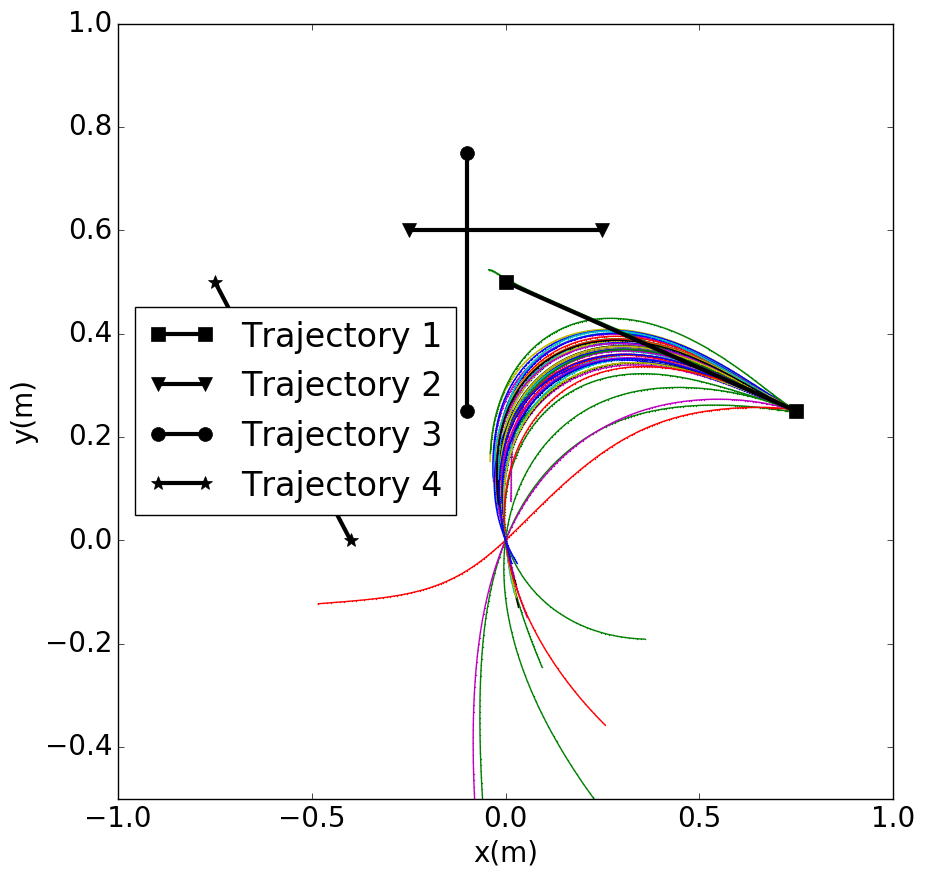

In [44]:
plt.figure(figsize =(10,10))

for tji in [1]:
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    for run_number in range(1,total_trials+1):
        teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        H,E = joints_to_hand(teta,aparams)
        plt.plot(H[:,0],H[:,1],'.-',markersize=1)
for tji in [1,2,3,4]:
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    plt.plot([xstart,xdest],[ystart,ydest],['ks-','kv-','ko-','k*-'][tji-1], markersize=10, linewidth=3, label='Trajectory '+str(tji))

# plt.title("Trajectories Generated - Set " + sim_set[-1])
plt.xlabel("x(m)")
plt.ylabel("y(m)")

plt.xlim(-1,1)
plt.ylim(-.5,1)

plt.legend(loc=0)
plt.savefig("All_Trajectories_"+sim_set+".png", bbox_inches='tight',pad_inches=1,dpi=300)
plt.show()

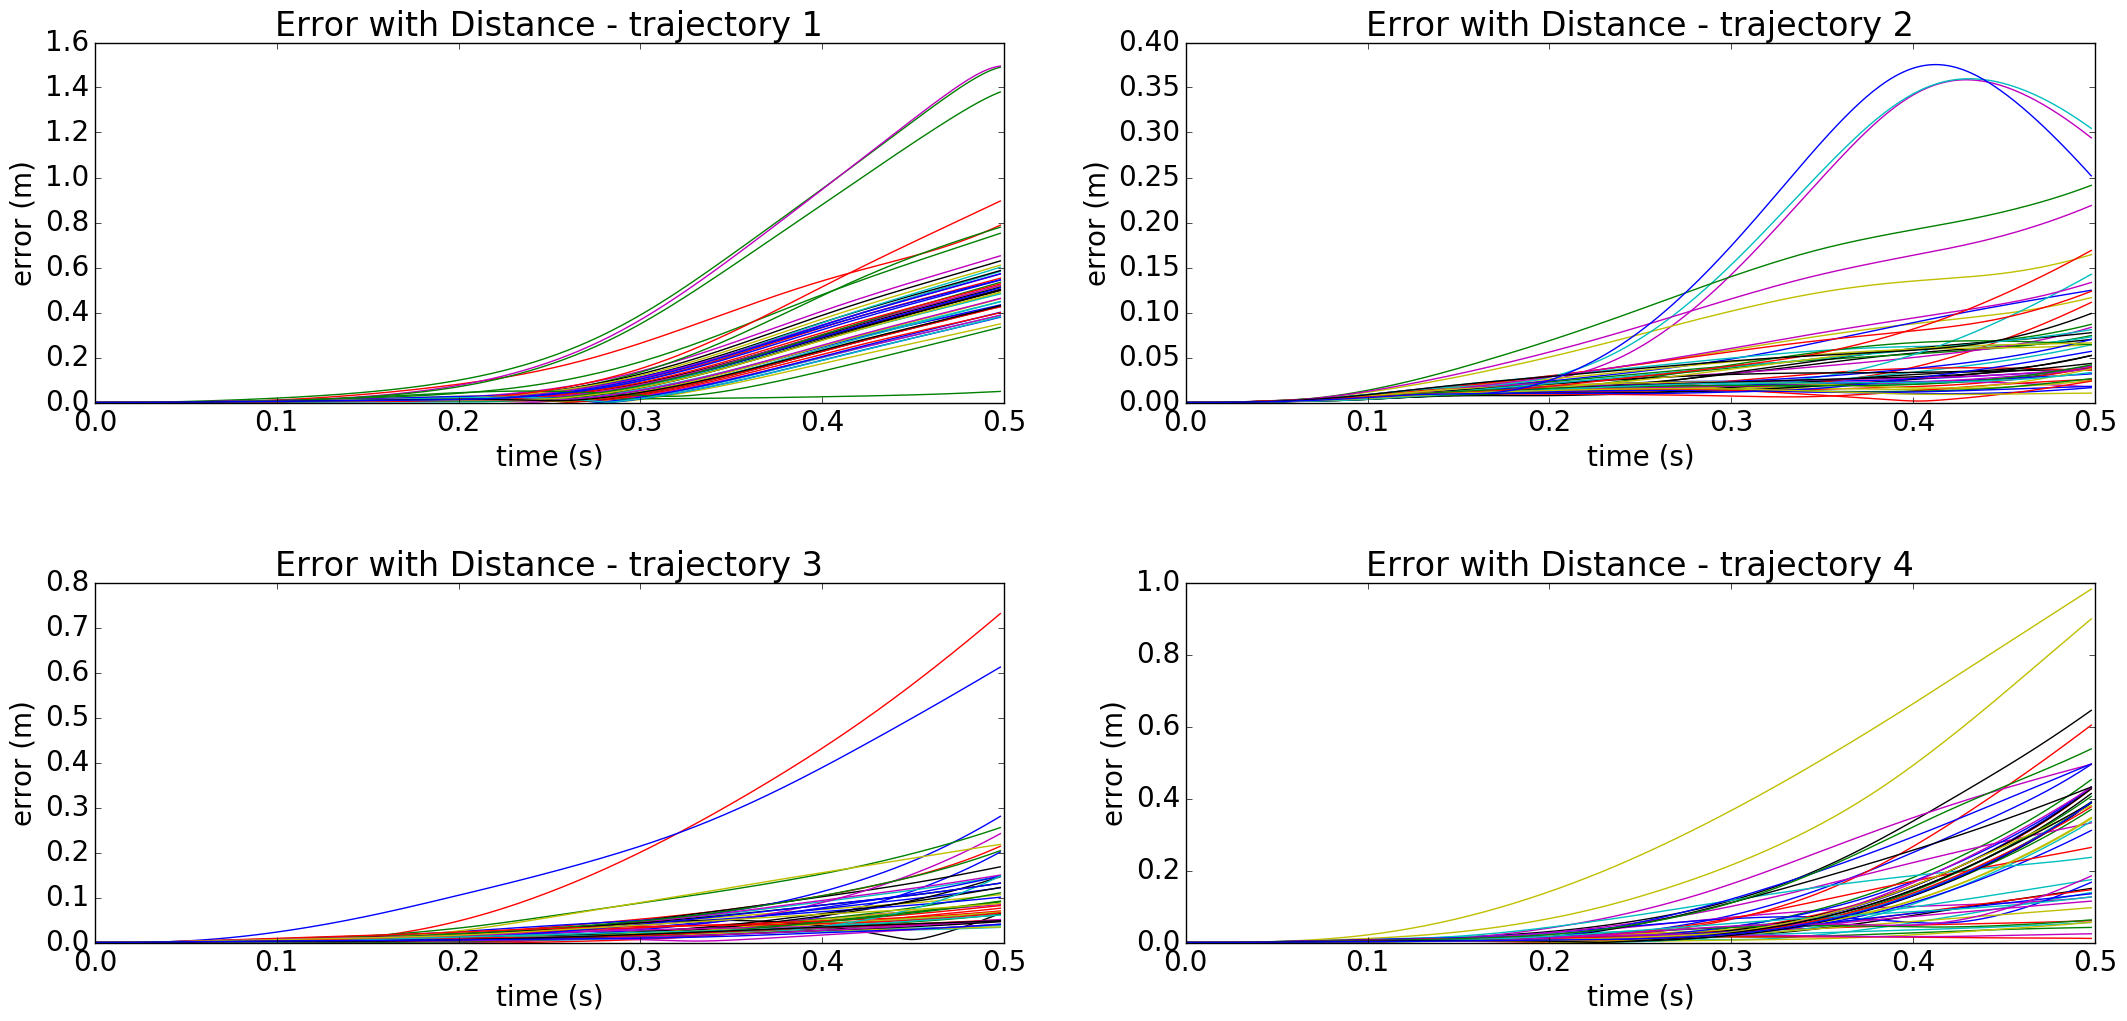

In [45]:
plt.figure(figsize =(20,10))
noiselevel=0
decimationlevel=0

subplti=1
for tji in range(1,5):
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    H_path=cartesian_movement_generation_training(xstart, ystart, xdest, ydest, .5, t_mov)

    plt.subplot(2,2,subplti)
    subplti+=1
    for run_number in range(1,total_trials+1):
        teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        H,E = joints_to_hand(teta,aparams)
        v1,v2=numpy.array([H_path[:,0],H_path[:,1]]),numpy.array([H[:,0][:len(H_path[:,0])],H[:,1][:len(H_path[:,0])]])
        plt.plot(t_mov,numpy.sqrt(((v2-v1)**2).sum(axis=0)))
    plt.ylabel("error (m)")
    plt.xlabel("time (s)")
    plt.title("Error with Distance - trajectory " + str(tji))
plt.subplots_adjust(left=0, bottom=.1, right=1, top=1,wspace=.2, hspace=.5)    
# plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_error_all_"+sim_set+".pdf")
plt.show()

# Now I'm using all sets

In [46]:
sim_sets

['set_A', 'set_B', 'set_C', 'set_D']

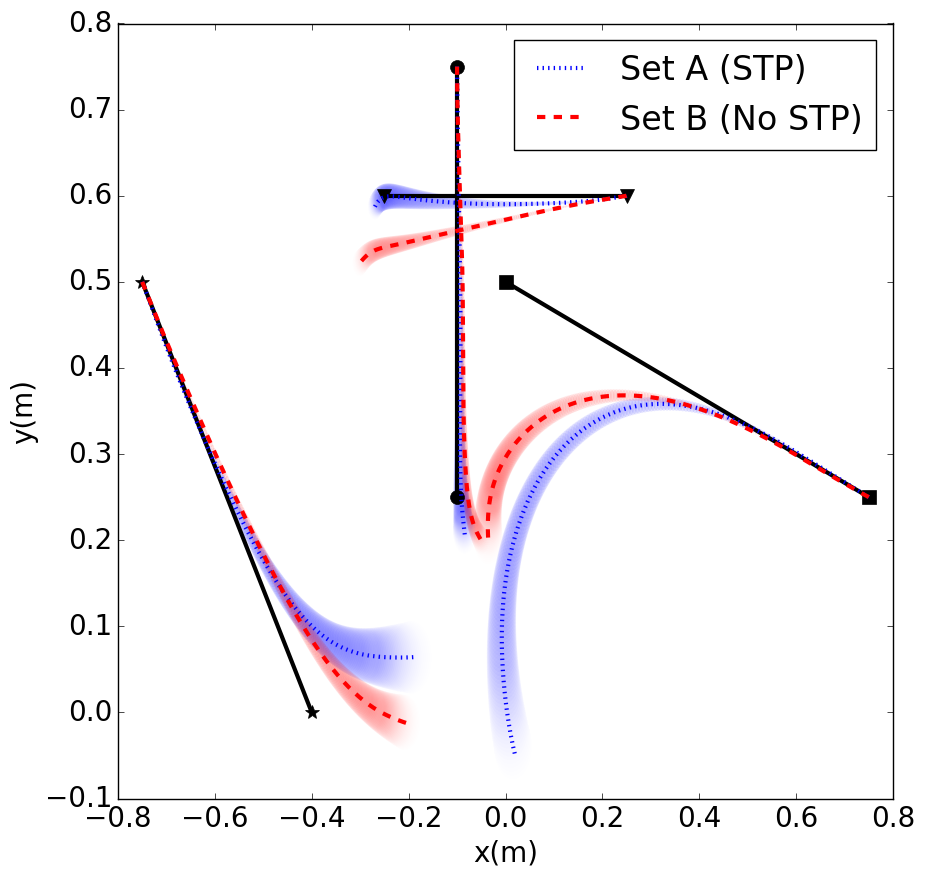

In [50]:
sets_list = [0,1]

plt.figure(figsize =(10,10))
noiselevel=0
decimationlevel=0

sim_set = sim_sets[sets_list[0]]

traj_results = slf.load_from_file("./"+"traj_results"+sim_set+".pickles")


for tji in range(1,5):
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    H_list=traj_results[tji-1]
    H_list_mean1 = H_list[tji-1,:,:,0].mean(axis=0)
    H_list_mean2 = H_list[tji-1,:,:,1].mean(axis=0)
    std_error1 = H_list[tji-1,:,:,0].std(axis=0)/numpy.sqrt(total_trials)
    std_error2 = H_list[tji-1,:,:,1].std(axis=0)/numpy.sqrt(total_trials)
    plt.plot([xstart,xdest],[ystart,ydest],['ks-','kv-','ko-','k*-'][tji-1], markersize=10, linewidth=3)
    dist = numpy.sqrt(std_error1**2+std_error2**2)
    
    ax=plt.gca()
    alpha = numpy.linspace(0.2,0,len(H_list_mean1))
    for x,y,r,a in zip(H_list_mean1,H_list_mean2,dist,alpha):
        ax.add_artist(plt.Circle((x, y), r, color='blue', alpha=a, linewidth=0)
    )
    if tji==1:
        plt.plot(H_list_mean1,H_list_mean2,'b:',linewidth=3, label='Set '+sim_set[-1]+' (STP)')
    else:
        plt.plot(H_list_mean1,H_list_mean2,'b:',linewidth=3)


sim_set = sim_sets[sets_list[1]]

traj_results = slf.load_from_file("./"+"traj_results"+sim_set+".pickles")


for tji in range(1,5):
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    H_list=traj_results[tji-1]
    H_list_mean1 = H_list[tji-1,:,:,0].mean(axis=0)
    H_list_mean2 = H_list[tji-1,:,:,1].mean(axis=0)
    std_error1 = H_list[tji-1,:,:,0].std(axis=0)/numpy.sqrt(total_trials)
    std_error2 = H_list[tji-1,:,:,1].std(axis=0)/numpy.sqrt(total_trials)
    dist = numpy.sqrt(std_error1**2+std_error2**2)
    ax=plt.gca()
    alpha = numpy.linspace(0.2,0,len(H_list_mean1))
    for x,y,r,a in zip(H_list_mean1,H_list_mean2,dist,alpha):
        ax.add_artist(plt.Circle((x, y), r, color='red', alpha=a, linewidth=0)
    )
    if tji==1:
        plt.plot(H_list_mean1,H_list_mean2,'r--',linewidth=3, label='Set '+sim_set[-1]+' (No STP)')
    else:
        plt.plot(H_list_mean1,H_list_mean2,'r--',linewidth=3)
    

plt.xlabel("x(m)")
plt.ylabel("y(m)")

plt.xlim(-.8,.8)
plt.ylim(-.1,0.8)
plt.legend(loc=0)
plt.savefig('All_Trajectories_sets_'+sim_sets[sets_list[0]][-1]+'_'+sim_sets[sets_list[1]][-1]+'.png', bbox_inches='tight',pad_inches=1,dpi=300)

plt.show()

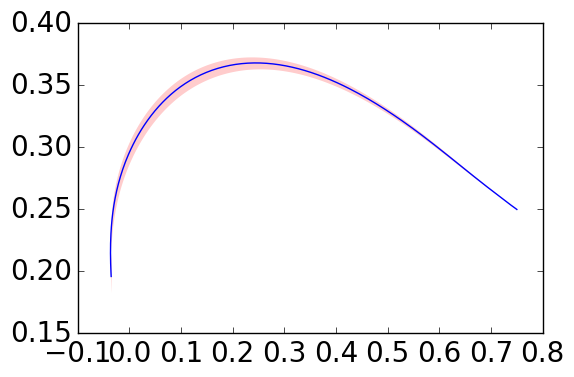

In [51]:
# Using the fill_between doesn't work...
n = 0
H_list=traj_results[n]
H_list_mean1 = H_list[n,:,:,0].mean(axis=0)
H_list_mean2 = H_list[n,:,:,1].mean(axis=0)
std_error1 = (H_list[tji-1,:,:,0].std(axis=0)/numpy.sqrt(total_trials))
std_error2 = (H_list[tji-1,:,:,1].std(axis=0)/numpy.sqrt(total_trials))
ax=plt.gca()
ax.fill_between(H_list_mean1, H_list_mean2+std_error2, H_list_mean2-std_error2, facecolor='red', alpha=0.2, linewidth=0)
plt.plot(H_list_mean1,H_list_mean2)
plt.show()

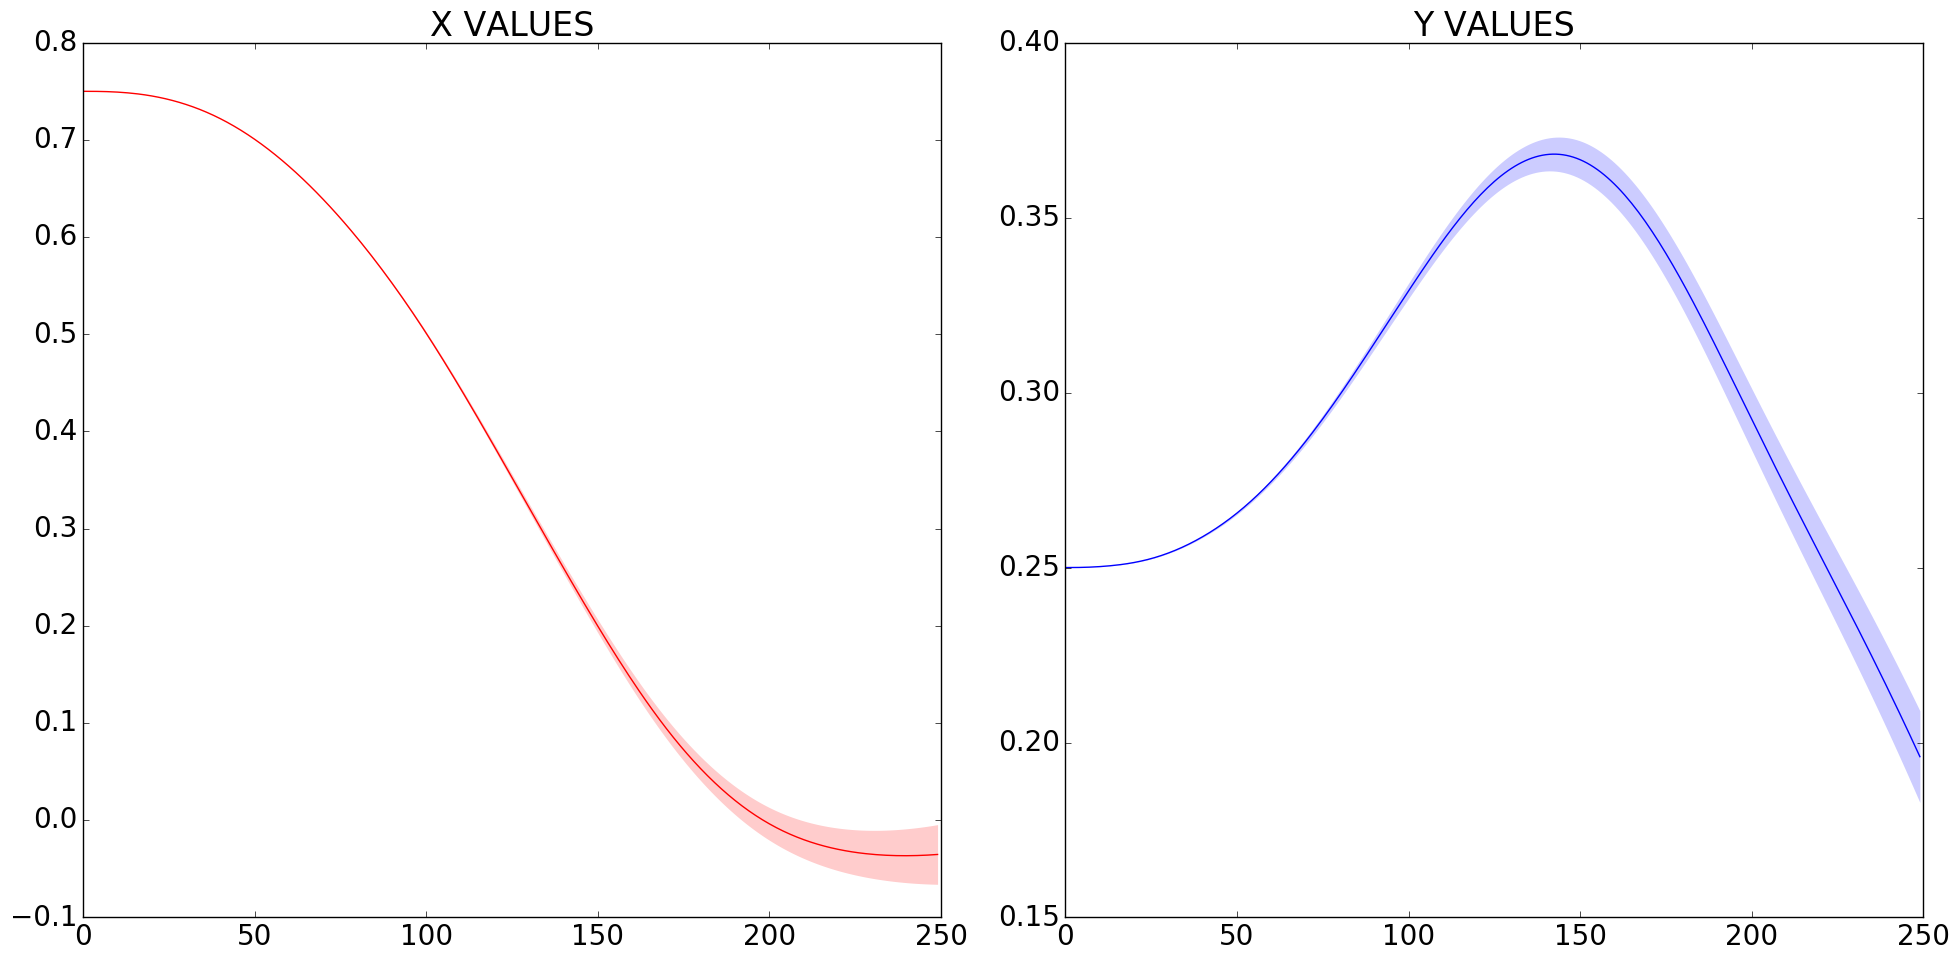

In [54]:
# ...because the variance is on X and Y.
plt.figure(figsize=(20,10))
plt.subplot(121)
ax = plt.gca()
ax.fill_between(range(len(H_list_mean1)), H_list_mean1+std_error1, H_list_mean1-std_error1, facecolor='red', alpha=0.2, linewidth=0)
plt.plot(H_list_mean1,'r-', label="x values")
plt.title("X VALUES")

plt.subplot(122)
ax = plt.gca()
ax.fill_between(range(len(H_list_mean2)), H_list_mean2+std_error2, H_list_mean2-std_error2, facecolor='blue', alpha=0.2, linewidth=0)
plt.plot(H_list_mean2, 'b-', label="y values")
plt.title("Y VALUES")

plt.tight_layout()
plt.show()

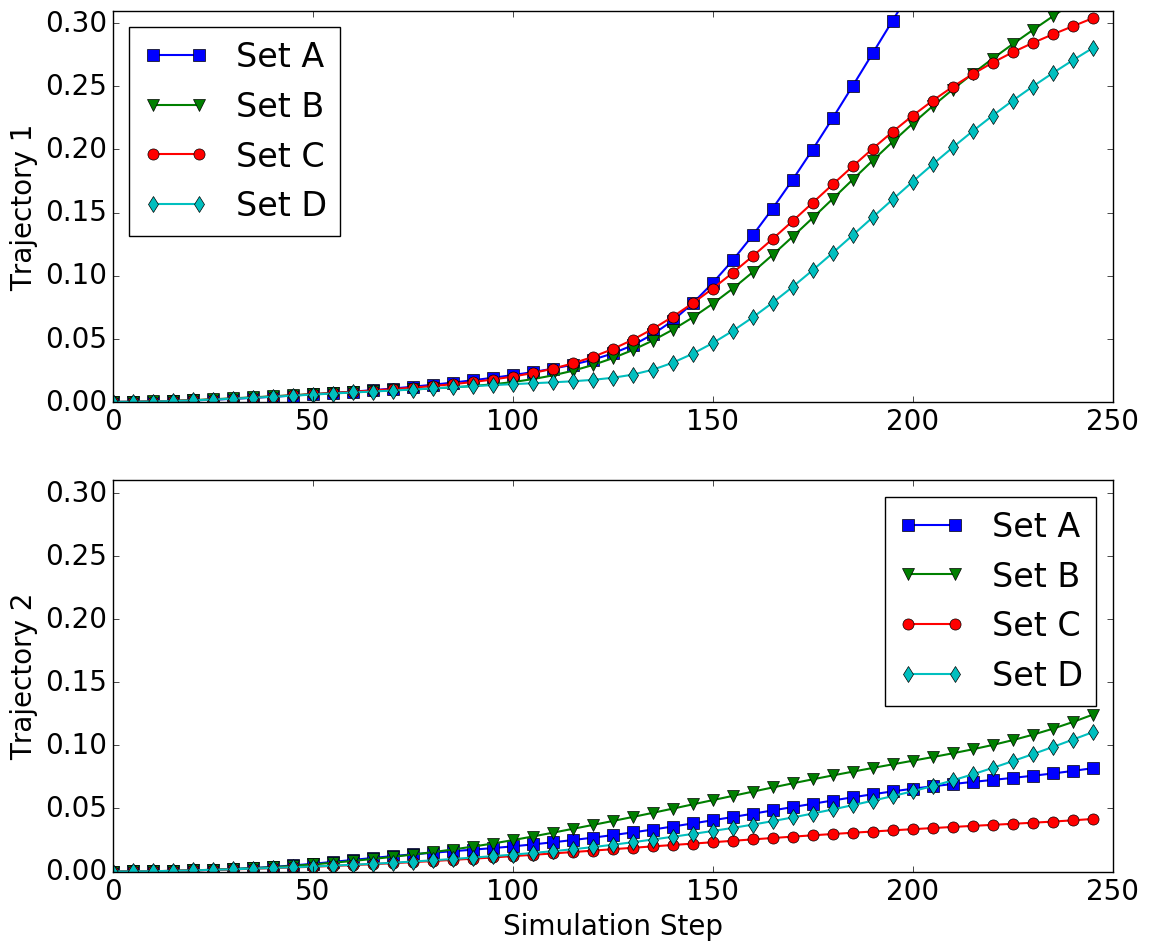

In [22]:
tji_list = [1,2]

plt.figure(figsize =(10,20))
noiselevel=0
decimationlevel=0

error_dist = numpy.zeros((4,total_trials,250))
subplti=1
for tji in tji_list:
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    H_path=cartesian_movement_generation_training(xstart, ystart, xdest, ydest, .5, t_mov)

    plt.subplot(4,1,subplti)
    subplti+=1
    for i,set_i in enumerate(sim_sets):
        for run_number in range(1,total_trials+1):
            teta = slf.load_from_file("./"+base_dir+"/"+set_i+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
            H,E = joints_to_hand(teta,aparams)
            v1,v2=numpy.array([H_path[:,0],H_path[:,1]]),numpy.array([H[:,0][:len(H_path[:,0])],H[:,1][:len(H_path[:,0])]])
            error_dist[tji-1,run_number-1,:] = numpy.copy(numpy.sqrt(((v2-v1)**2).sum(axis=0)))
        error_dist_mean = error_dist[tji-1,:].mean(axis=0)
        error_dist_std_error = error_dist[tji-1,:].std(axis=0)/numpy.sqrt(total_trials)
#         plt.plot(range(250),error_dist_mean+error_dist_std_error,'r--',markersize=1)
#         plt.plot(range(250),error_dist_mean-error_dist_std_error,'r--',markersize=1)    
        plt.plot(range(250)[::5],error_dist_mean[::5],['s-','v-','o-','d-'][i],linewidth=1.5,
                 markersize=8,
                 label="Set "+set_i[-1])
    
    plt.ylabel("Trajectory " +  str(tji))
    if tji==2 or tji==4:
        plt.xlabel("Simulation Step")
    
    plt.ylim(0,0.31)
        
    plt.legend(loc=0)
#     plt.title("Error Distance - Mean Value and Standard Error\n Trajectory " + str(tji))
plt.subplots_adjust(left=0, bottom=.1, right=1, top=1, wspace=.2, hspace=.2)    
plt.savefig("readout_testing_error_all_mean_"+str(tji_list[0])+"-"+str(tji_list[1])+".pdf", bbox_inches='tight',pad_inches=1)
plt.show()

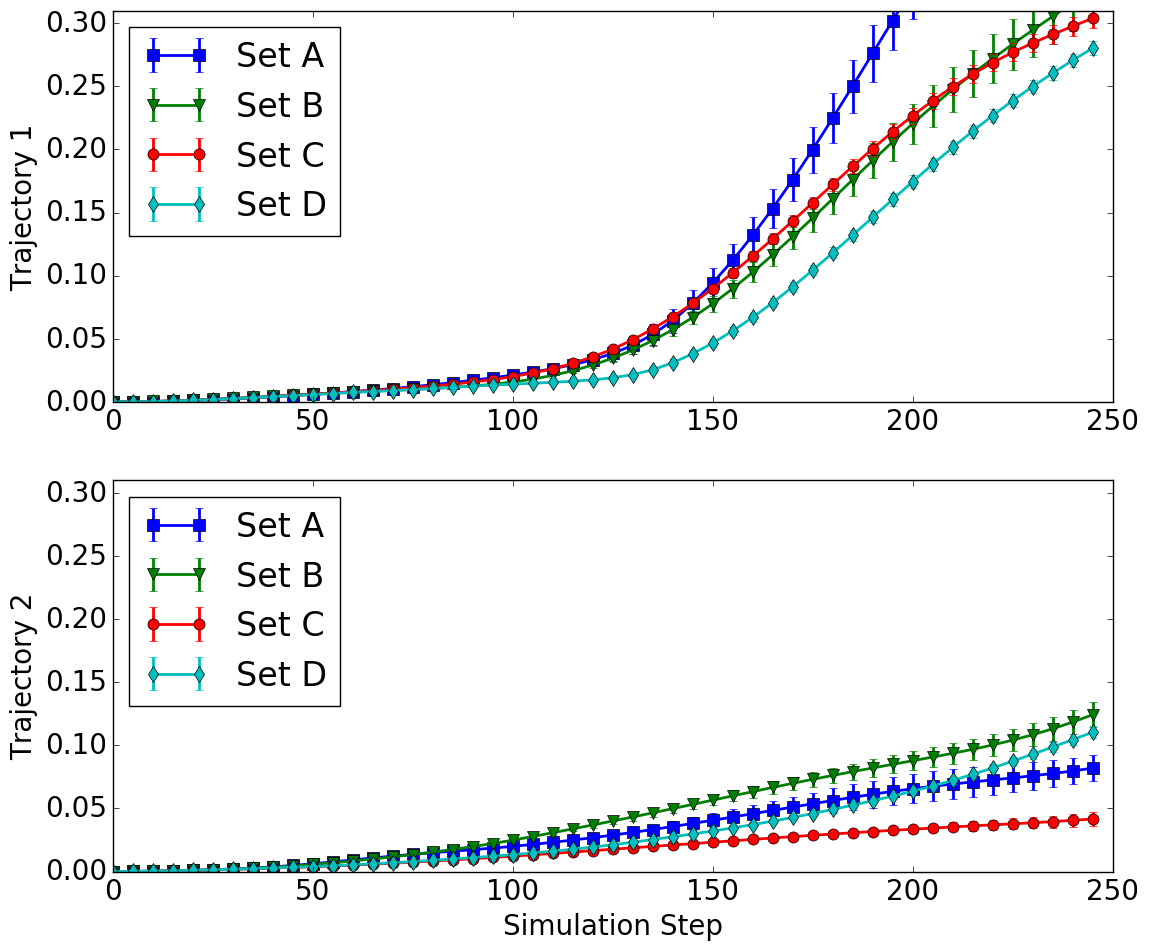

In [23]:
tji_list = [1,2]

plt.figure(figsize =(10,20))
noiselevel=0
decimationlevel=0

error_dist = numpy.zeros((4,total_trials,250))
subplti=1
for tji in tji_list:
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    H_path=cartesian_movement_generation_training(xstart, ystart, xdest, ydest, .5, t_mov)

    plt.subplot(4,1,subplti)
    subplti+=1
    for i,set_i in enumerate(sim_sets):
        for run_number in range(1,total_trials+1):
            teta = slf.load_from_file("./"+base_dir+"/"+set_i+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
            H,E = joints_to_hand(teta,aparams)
            v1,v2=numpy.array([H_path[:,0],H_path[:,1]]),numpy.array([H[:,0][:len(H_path[:,0])],H[:,1][:len(H_path[:,0])]])
            error_dist[tji-1,run_number-1,:] = numpy.copy(numpy.sqrt(((v2-v1)**2).sum(axis=0)))
        error_dist_mean = error_dist[tji-1,:].mean(axis=0)
        error_dist_std_error = error_dist[tji-1,:].std(axis=0)/numpy.sqrt(total_trials)
#         plt.plot(range(250),error_dist_mean+error_dist_std_error,'r--',markersize=1)
#         plt.plot(range(250),error_dist_mean-error_dist_std_error,'r--',markersize=1)    

        plt.errorbar(range(250)[::5],\
                     error_dist_mean[::5],\
                     error_dist_std_error[::5],\
                     linestyle='-', marker=['s','v','o','d'][i], label="Set "+set_i[-1], linewidth=2, markersize=8)
    
    plt.ylabel("Trajectory " +  str(tji))
    if tji==2 or tji==4:
        plt.xlabel("Simulation Step")
        
    plt.ylim(0,0.31)
    plt.legend(loc=0)
#     plt.title("Error Distance - Mean Value and Standard Error\n Trajectory " + str(tji))
plt.subplots_adjust(left=0, bottom=.1, right=1, top=1, wspace=.2, hspace=.2)    
plt.savefig("readout_testing_error_all_mean_errorbar"+str(tji_list[0])+"-"+str(tji_list[1])+".pdf", bbox_inches='tight',pad_inches=1)
plt.show()

In [ ]:
noiselevel=0
decimationlevel=0

plt.figure(figsize =(20,10))

subploti=1
for tji in range(1,5):
    torques_original = numpy.array([torques_all_1[(tji-1)*250:(tji)*250],torques_all_2[(tji-1)*250:(tji)*250]])
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    ymin = numpy.array([torques_all_1.min(),torques_all_2.min()]).min()
    ymax = numpy.array([torques_all_1.max(),torques_all_2.max()]).max()

    torques_read_1=numpy.zeros((total_trials,250))
    torques_read_2=numpy.zeros((total_trials,250))


    plt.subplot(4,2,subploti)
    for run_number in range(1,total_trials+1):
        torques = slf.load_from_file("./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        torques_read_1[run_number-1] = numpy.copy(torques[:,0])
        plt.plot(torques[:,0],'.-',label="Tau1 Calculated")
    plt.plot(torques_original[0,:],'k-',label="Tau1 Original")
    plt.ylabel("Torque (Nm)")
    plt.xlabel("step")
    plt.title("Tau1 - trajectory " + str(tji))
    plt.xlim(0,250)
    # plt.legend()

    plt.subplot(4,2,subploti+1)
    subploti+=2
    for run_number in range(1,total_trials+1):
        torques = slf.load_from_file("./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        torques_read_2[run_number-1] = numpy.copy(torques[:,1])
        plt.plot(torques[:,1],'.-',label="Tau2 Calculated")
    plt.plot(torques_original[1,:],'k-',label="Tau2 Original")
    plt.xlim(0,250)
    plt.ylabel("Torque (Nm)")
    plt.xlabel("step")
    plt.title("Tau2 - trajectory " + str(tji))
    # plt.ylim(ymin,ymax)
    # plt.legend()
    
plt.subplots_adjust(left=0, bottom=.1, right=1, top=1, wspace=.2, hspace=.8)
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_testing_all_"+sim_set+".pdf", bbox_inches='tight',pad_inches=1)
plt.show()

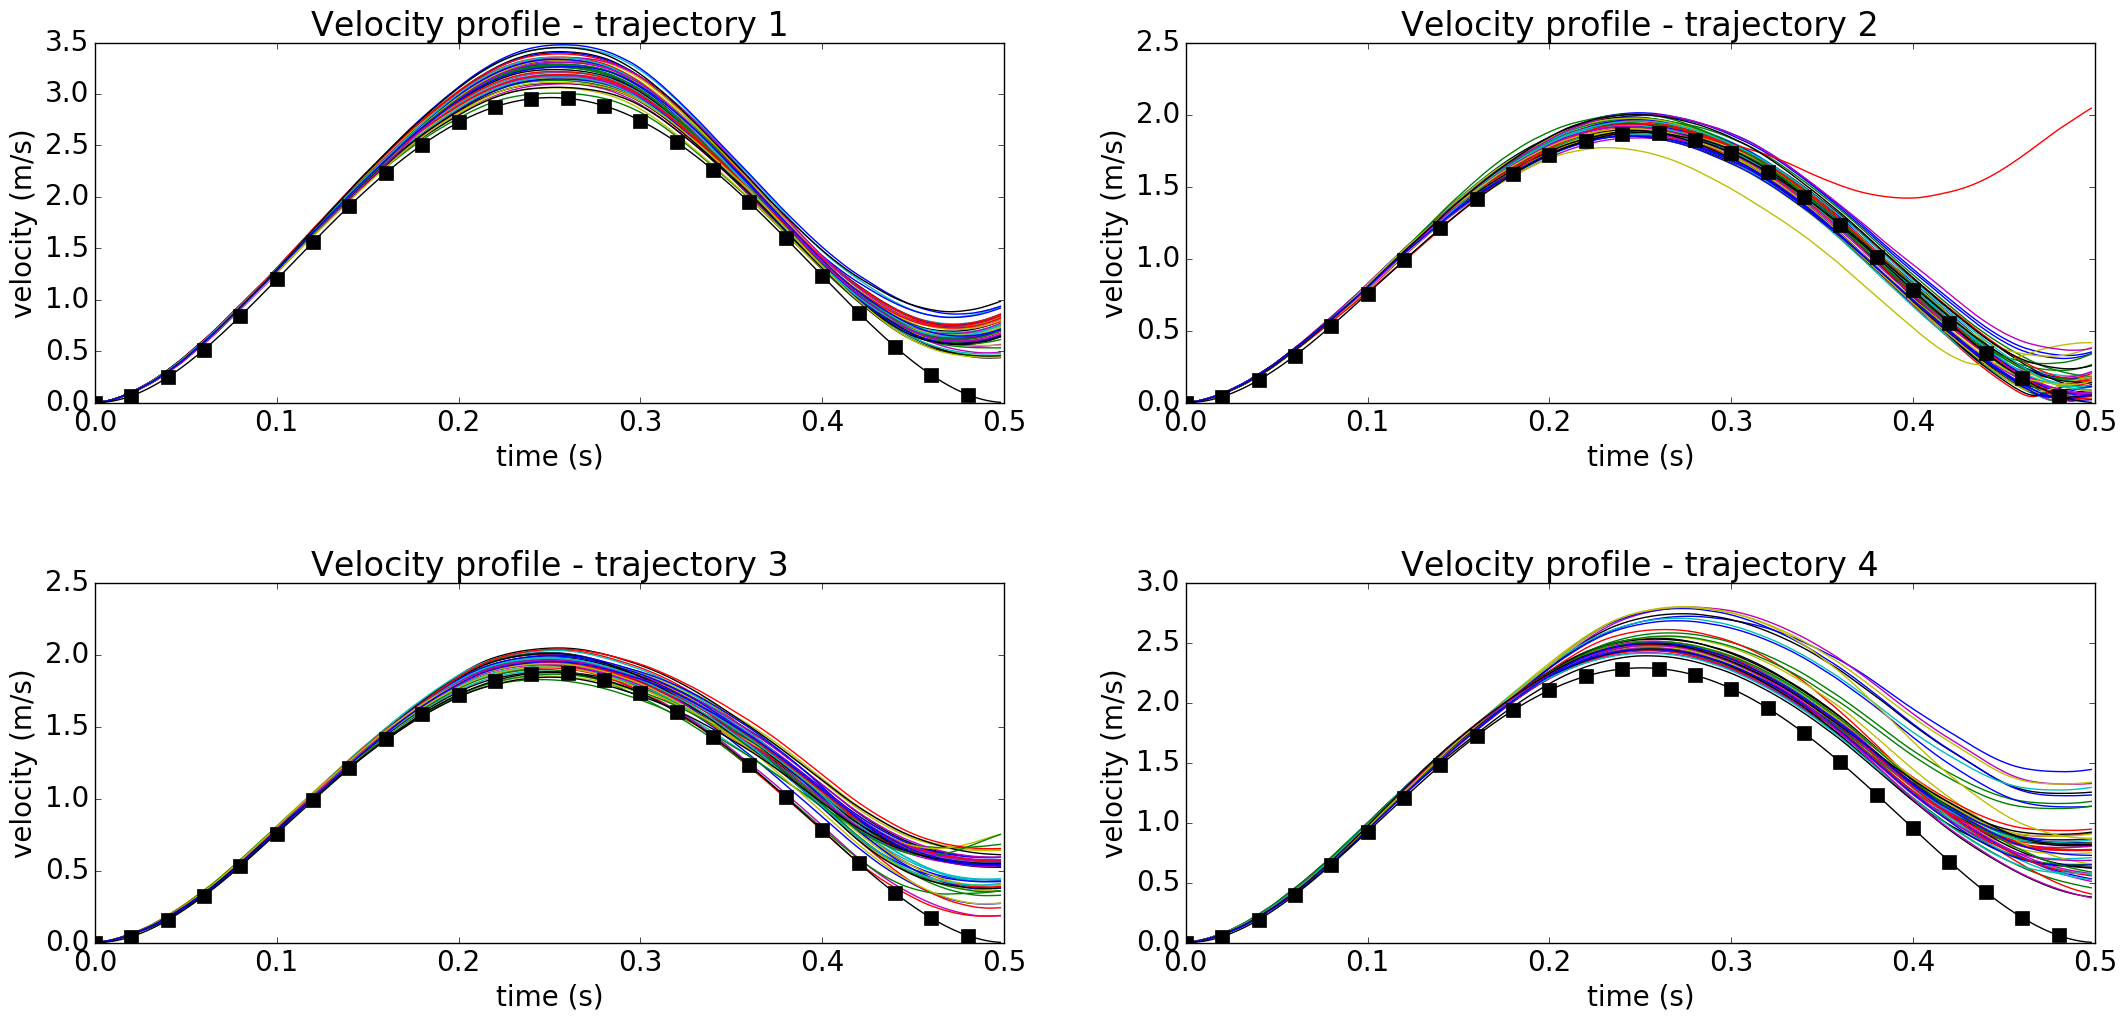

In [42]:
plt.figure(figsize =(20,10))
noiselevel=0
decimationlevel=0

subplti=1
for tji in range(1,5):
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    H_path=cartesian_movement_generation_training(xstart, ystart, xdest, ydest, .5, t_mov)

    plt.subplot(2,2,subplti)
    subplti+=1
    for run_number in range(1,total_trials+1):
        teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        H,E = joints_to_hand(teta,aparams)
        plt.plot(t_mov,numpy.sqrt(numpy.concatenate(([0], derivator(H[:,0],t_mov)))**2+numpy.concatenate(([0], derivator(H[:,1],t_mov)))**2),label="Resultant Velocity Vector")

    plt.plot(t_mov,numpy.sqrt(numpy.concatenate(([0], derivator(H_path[:,0],t_mov)))**2+numpy.concatenate(([0], derivator(H_path[:,1],t_mov)))**2),'ks-',markersize=10, markevery=10)
    plt.title("Velocity profile - trajectory "+str(tji))
    plt.ylabel("velocity (m/s)")
    plt.xlabel("time (s)")
plt.subplots_adjust(left=0, bottom=.1, right=1, top=1,wspace=.2, hspace=.5)    
# plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_velocity_all"+sim_set+".pdf", bbox_inches='tight',pad_inches=1)
plt.show()

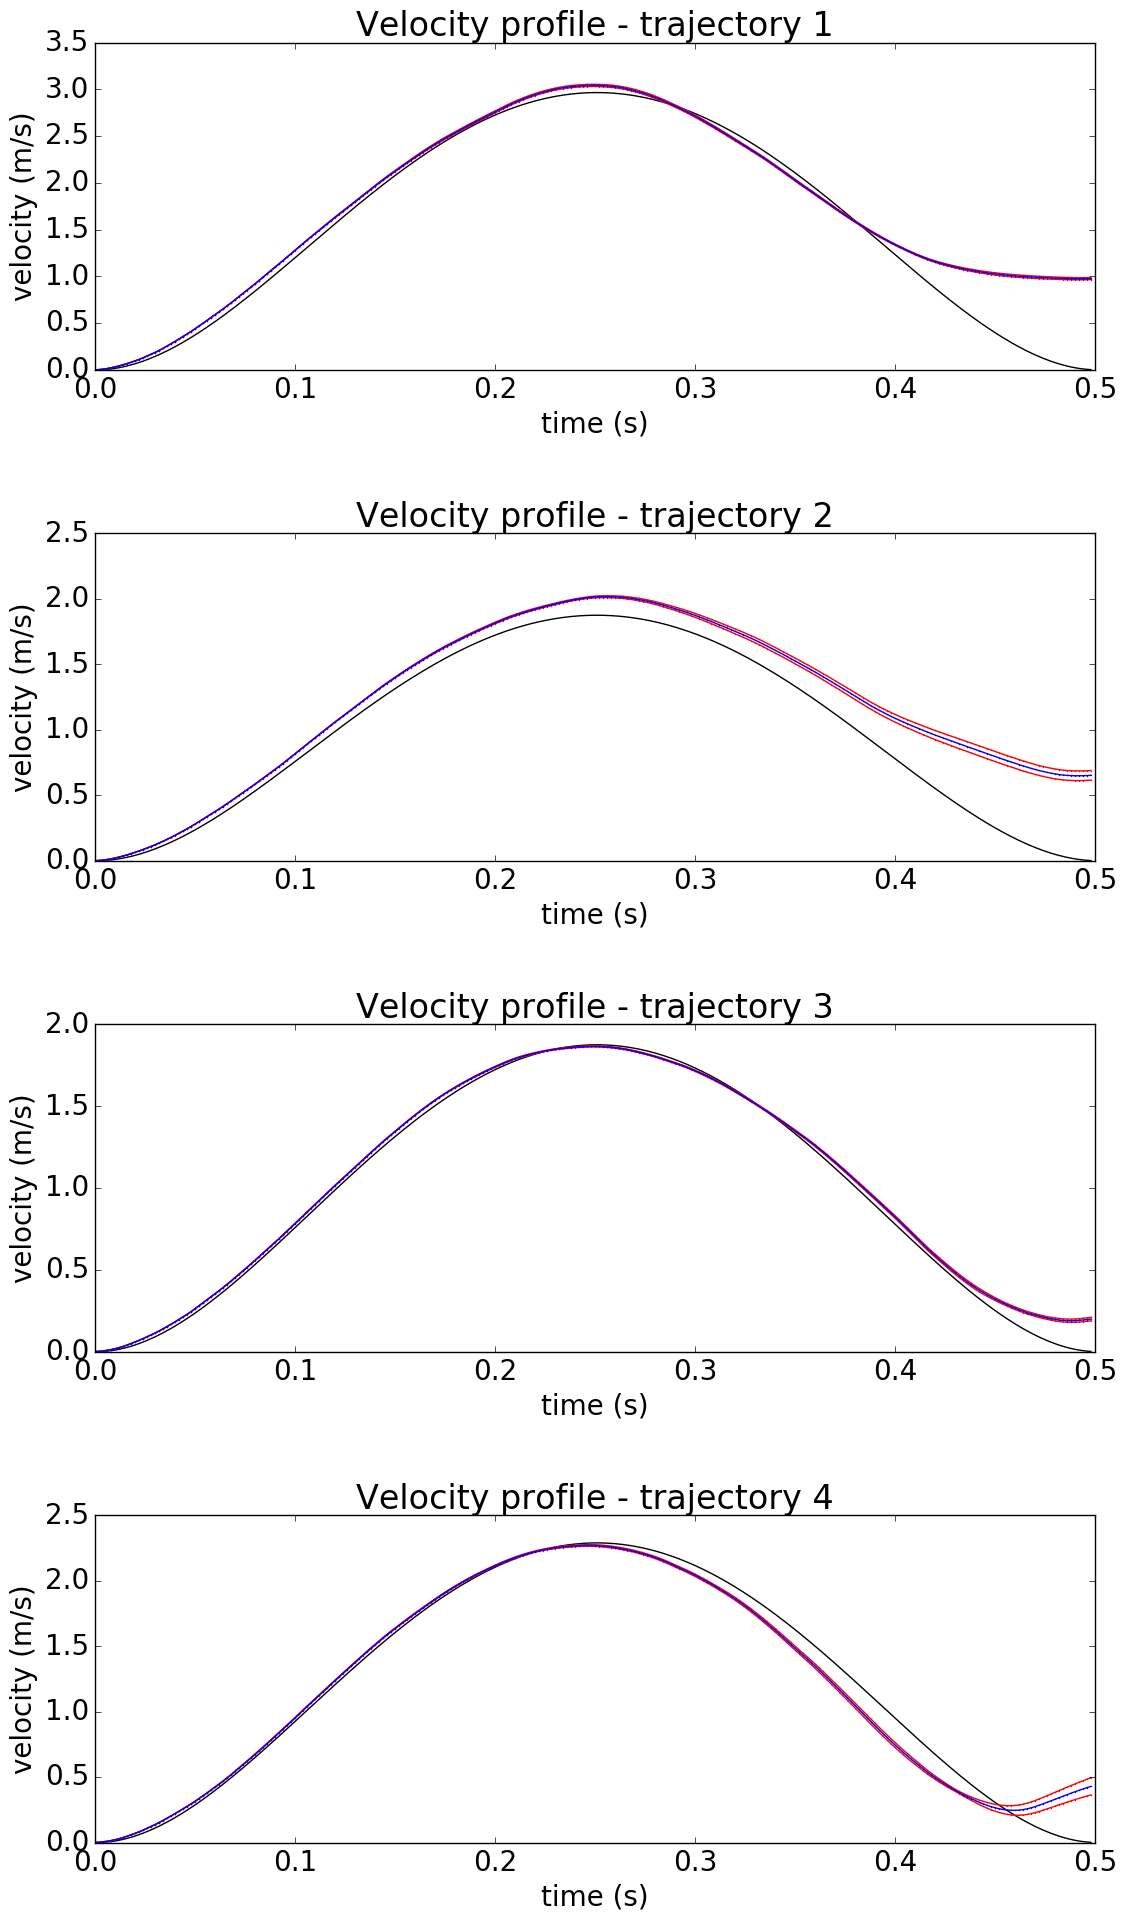

In [52]:
plt.figure(figsize =(10,20))
noiselevel=0
decimationlevel=0

subplti=1
for tji in range(1,5):
    x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
    H_path=cartesian_movement_generation_training(xstart, ystart, xdest, ydest, .5, t_mov)

    plt.subplot(4,1,subplti)
    subplti+=1
    plt.plot(t_mov,numpy.sqrt(numpy.concatenate(([0], derivator(H_path[:,0],t_mov)))**2+numpy.concatenate(([0], derivator(H_path[:,1],t_mov)))**2),'k-',markersize=5)
    
    H_velocity = numpy.zeros((total_trials,len(t_mov)))
    for run_number in range(1,total_trials+1):
        teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
        H,E = joints_to_hand(teta,aparams)
        H_velocity[run_number-1,:]=numpy.copy(numpy.sqrt(numpy.concatenate(([0], derivator(H[:,0],t_mov)))**2+numpy.concatenate(([0], derivator(H[:,1],t_mov)))**2))

    H_velocity_mean = H_velocity.mean(axis=0)
    H_velocity_std_error = H_velocity.std(axis=0)/numpy.sqrt(total_trials)
    
    plt.plot(t_mov,H_velocity_mean+H_velocity_std_error,'r.-',markersize=1)
    plt.plot(t_mov,H_velocity_mean-H_velocity_std_error,'r.-',markersize=1)
    plt.plot(t_mov,H_velocity_mean,'b.-',markersize=1)    
    plt.title("Velocity profile - trajectory "+str(tji))
    plt.ylabel("velocity (m/s)")
    plt.xlabel("time (s)")
plt.subplots_adjust(left=0, bottom=.1, right=1, top=1,wspace=.2, hspace=.5)    
# plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_velocity_all_mean_var_"+sim_set+".pdf", bbox_inches='tight',pad_inches=1)
plt.show()

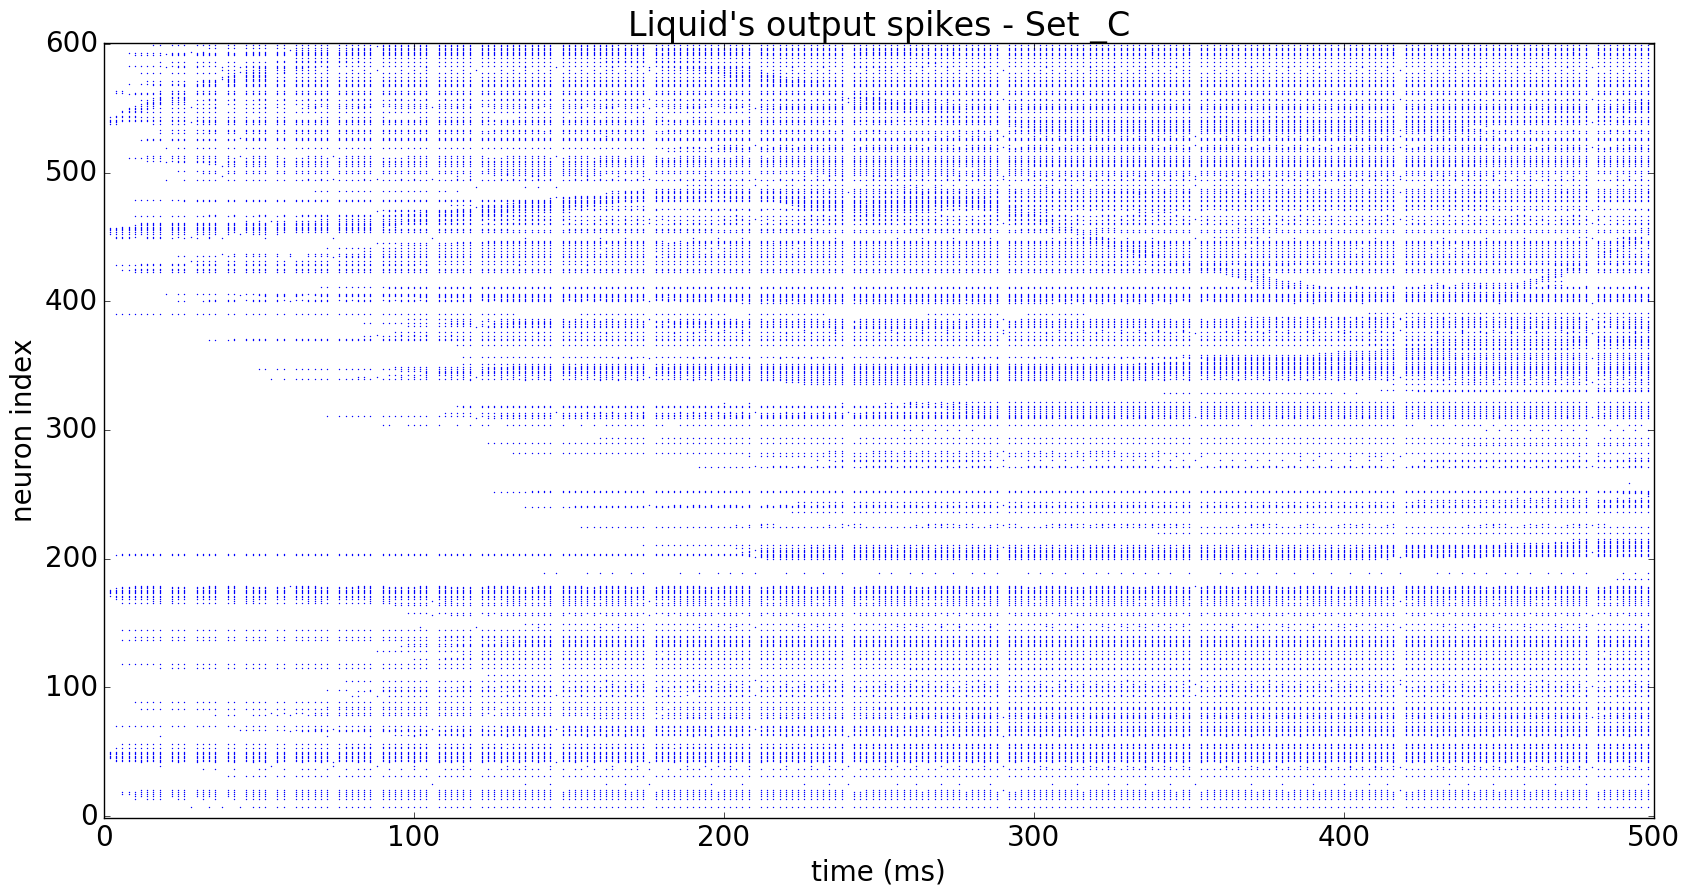

In [44]:
noiselevel=0
decimationlevel=0

tji=1

OutputSpks_save = slf.load_from_file("./"+base_dir+"/"+sim_set+"/OutputSpks_save_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")

y = numpy.array([j for i in OutputSpks_save for j in i[0]])
x = numpy.array([i[1] for i in OutputSpks_save for j in i[0]])

plt.figure(figsize =(20,10))
plt.plot(x*1000,y,'.',markersize=1)
# plt.xlim(-1,251)
plt.ylim(-1,601)
plt.ylabel("neuron index")
plt.xlabel("time (ms)")
plt.title("Liquid's output spikes - Set " + sim_set[-2:])
plt.show()

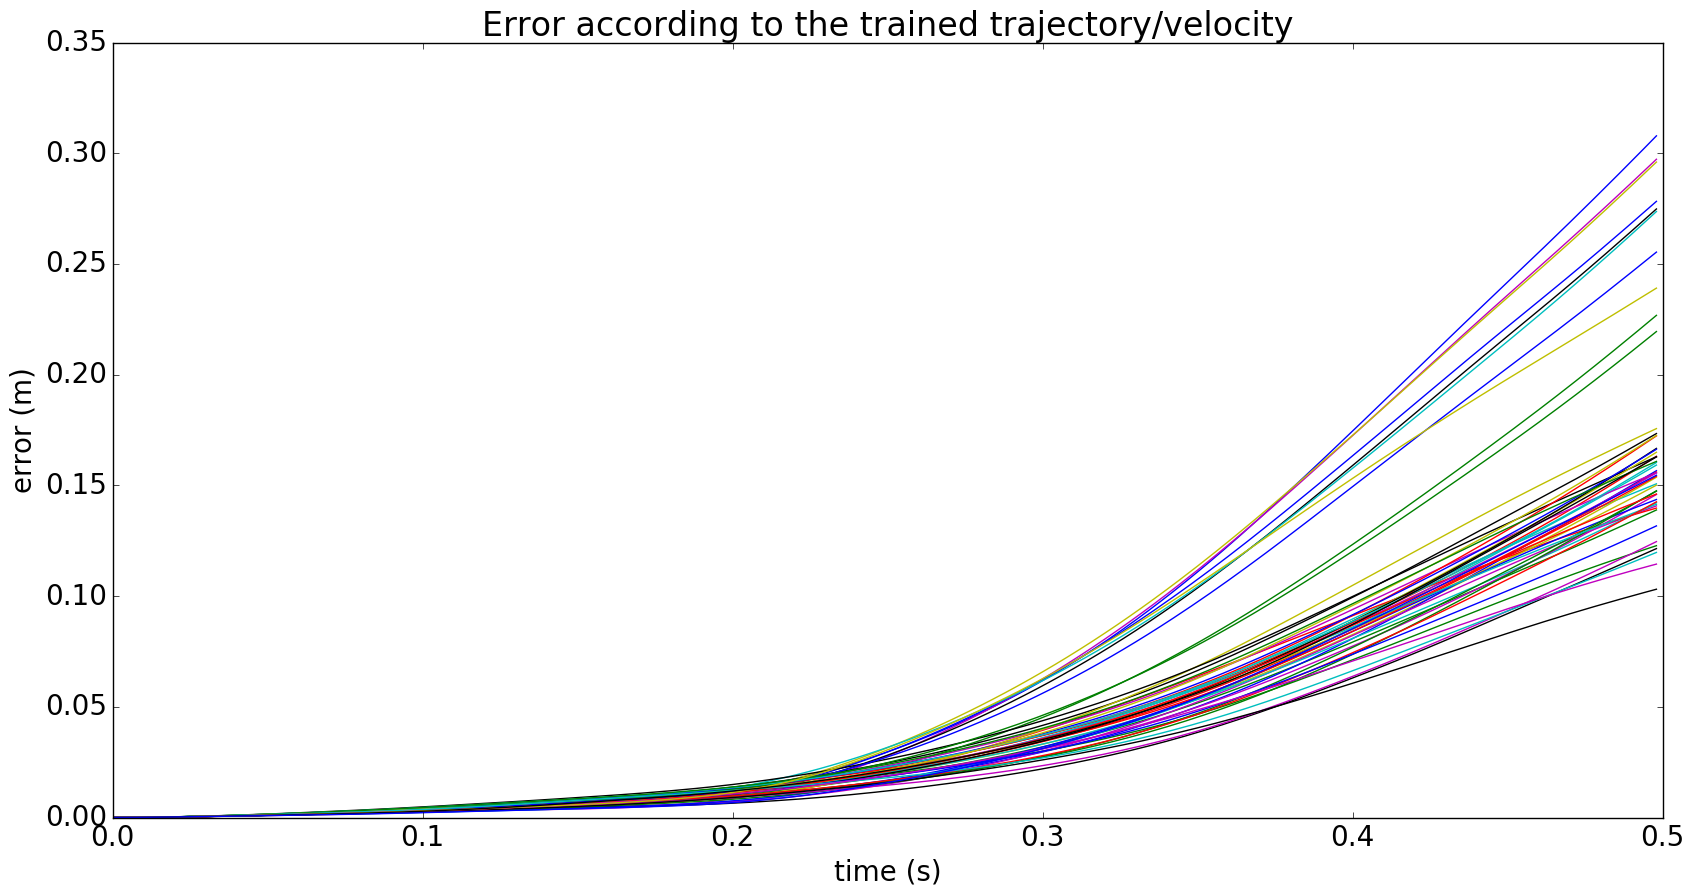

In [45]:
noiselevel=0
decimationlevel=0
tji=4
x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji,trajectories,x_values,y_values)
H_path=cartesian_movement_generation_training(xstart, ystart, xdest, ydest, .5, t_mov)

plt.figure(figsize =(20,10))
for run_number in range(1,total_trials+1):
    teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    H,E = joints_to_hand(teta,aparams)
    v1,v2=numpy.array([H_path[:,0],H_path[:,1]]),numpy.array([H[:,0][:len(H_path[:,0])],H[:,1][:len(H_path[:,0])]])
    plt.plot(t_mov,numpy.sqrt(((v2-v1)**2).sum(axis=0)))
plt.ylabel("error (m)")
plt.xlabel("time (s)")
plt.title("Error according to the trained trajectory/velocity")
# plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_error_"+str(tji)+".pdf")
plt.show()

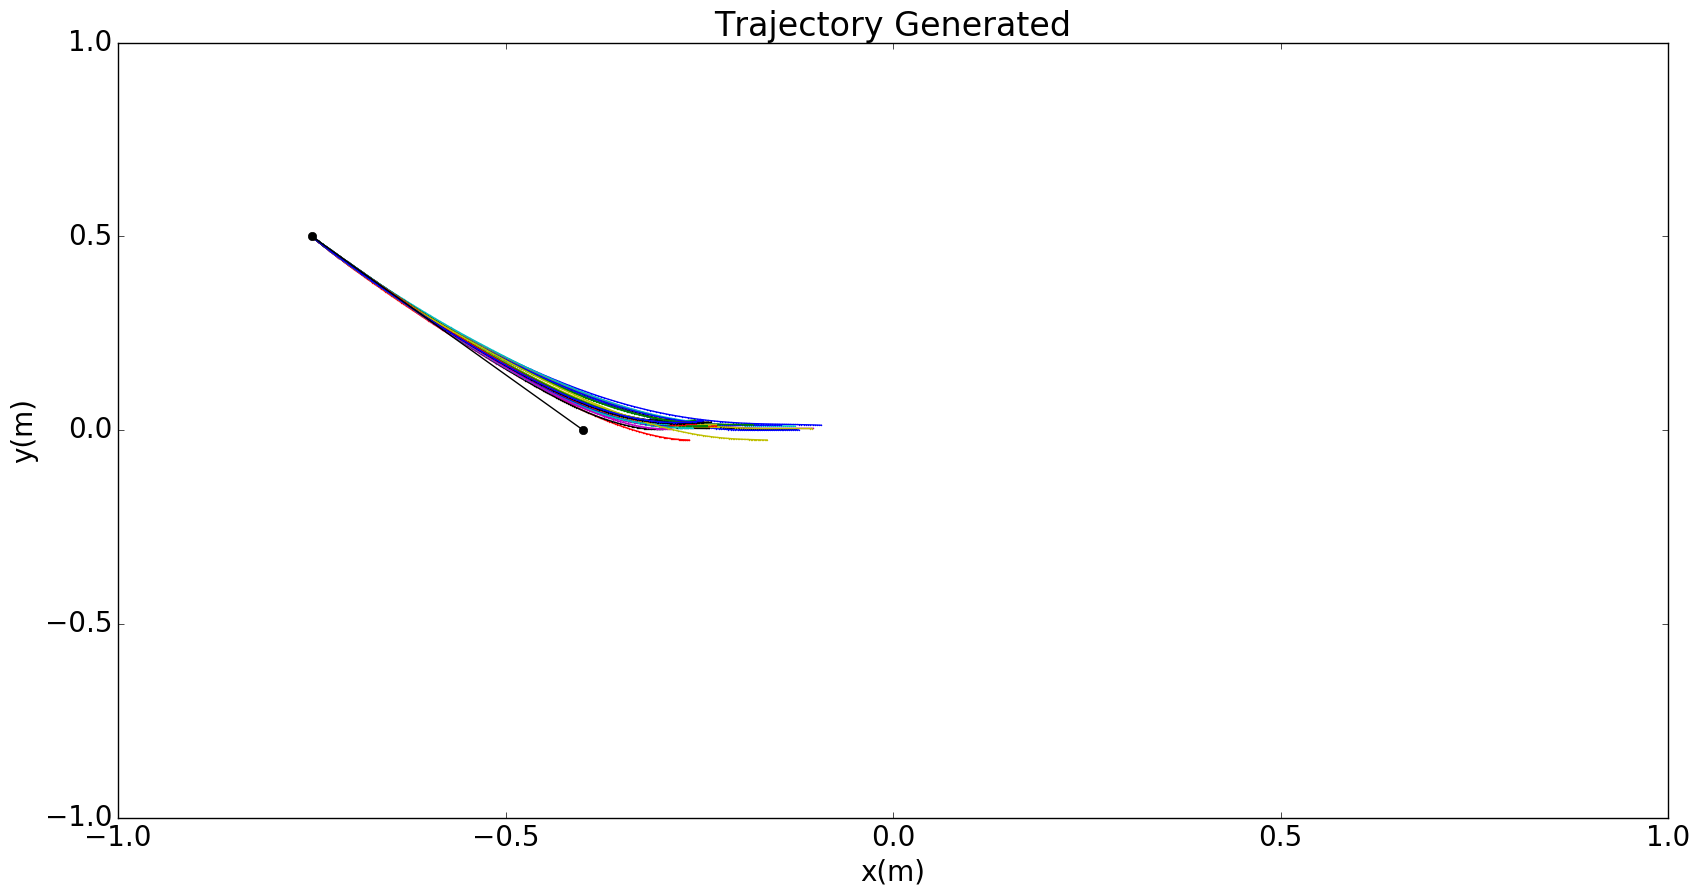

In [46]:
noiselevel=0
decimationlevel=0

plt.figure(figsize =(20,10))
for run_number in range(1,total_trials+1):
    teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    H,E = joints_to_hand(teta,aparams)
    plt.plot(H[:,0],H[:,1],'.-',markersize=1)
plt.plot([xstart,xdest],[ystart,ydest],'ko-')
plt.xlim(numpy.array([xstart,xdest]).min()-0.1,numpy.array([xstart,xdest]).max()+0.1)
plt.ylim(numpy.array([ystart,ydest]).min()-0.1,numpy.array([ystart,ydest]).max()+0.1)
plt.title("Trajectory Generated")
plt.xlabel("x(m)")
plt.ylabel("y(m)")
# plt.savefig("NRMSE_test__traj_bad.pdf")
plt.xlim(-1,1)
plt.ylim(-1,1)
# plt.xlim(-.14,-.06)
# plt.ylim(0.1,.8)
# plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_trajectory_"+str(tji)+".pdf")
plt.show()

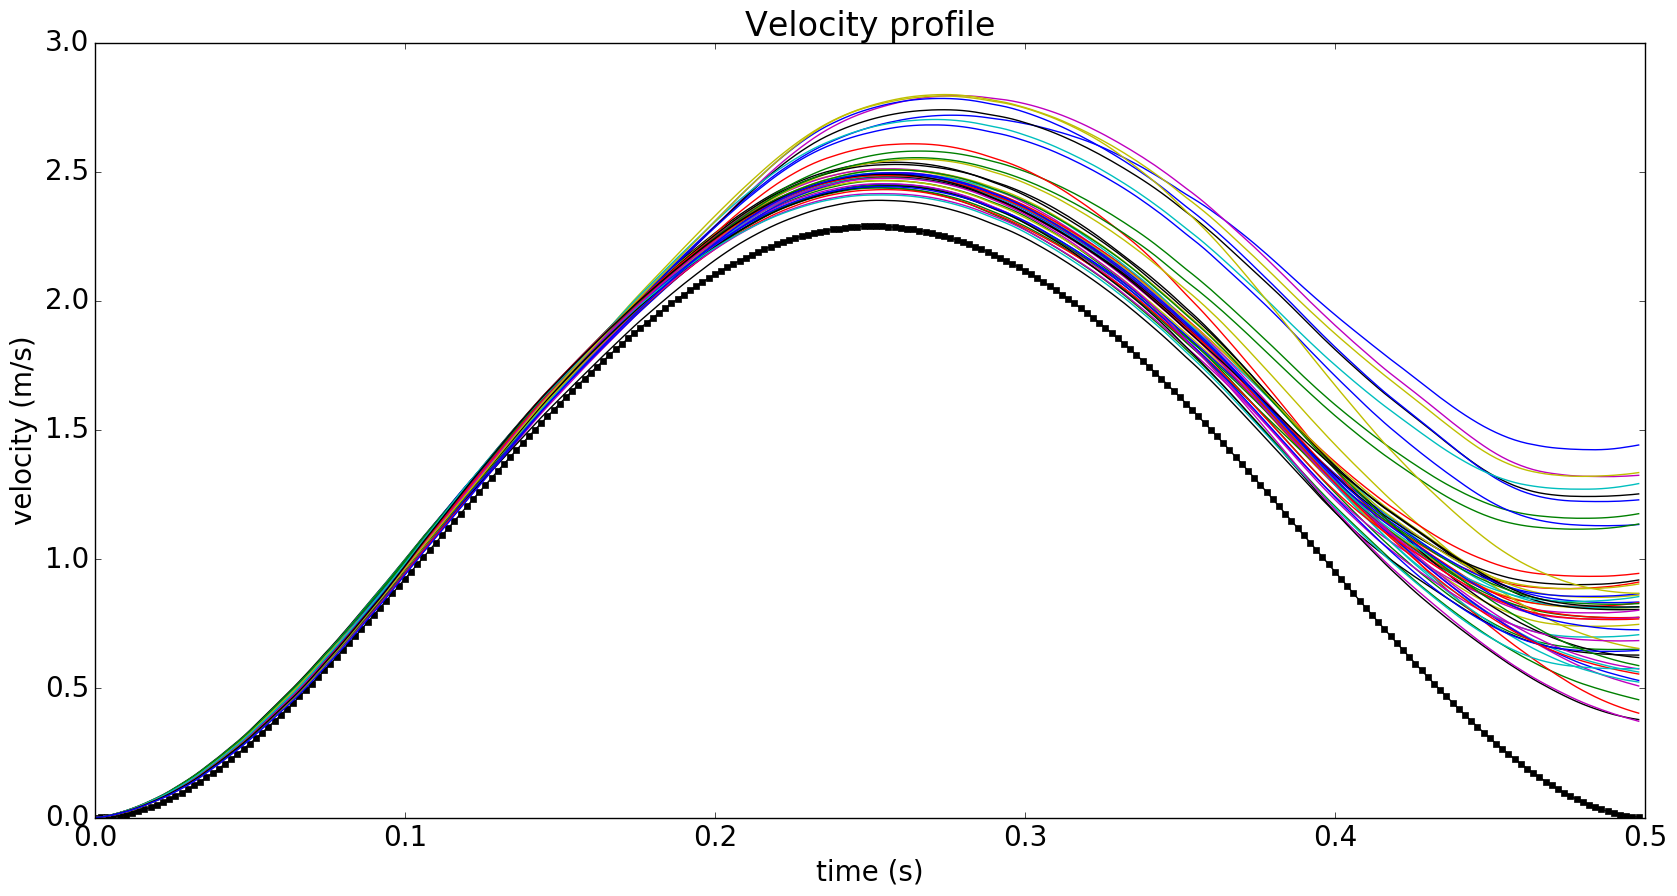

In [47]:
noiselevel=0
decimationlevel=0

plt.figure(figsize =(20,10))

plt.plot(t_mov,numpy.sqrt(numpy.concatenate(([0], derivator(H_path[:,0],t_mov)))**2+numpy.concatenate(([0], derivator(H_path[:,1],t_mov)))**2),'ks-',markersize=5, label="Resultant Velocity Vector")
for run_number in range(1,total_trials+1):
    teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    H,E = joints_to_hand(teta,aparams)
    plt.plot(t_mov,numpy.sqrt(numpy.concatenate(([0], derivator(H[:,0],t_mov)))**2+numpy.concatenate(([0], derivator(H[:,1],t_mov)))**2),label="Resultant Velocity Vector")
plt.title("Velocity profile")
plt.ylabel("velocity (m/s)")
plt.xlabel("time (s)")
# plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_velocity_"+str(tji)+".pdf")
plt.show()